<a href="https://colab.research.google.com/github/Mathews-Tom/Deep_Learning_with_TensorFlow_Zero_to_Mastery/blob/main/Notebooks/03_Convolutional_Neural_Networks_in_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. Convolutional Neural Networks and Computer Vision with TensorFlow

So far we've covered the basics of TensorFlow and built a handful of models to work across different problems.

Now we're going to get specific and see how a special kind of neural network, [convolutional neural networks (CNNs)](https://en.wikipedia.org/wiki/Convolutional_neural_network) can be used for computer vision (detecting patterns in visual data).

> 🔑 **Note:** In deep learning, many different kinds of model architectures can be used for different problems. For example, you could use a convolutional neural network for making predictions on image data and/or text data. However, in practice some architectures typically work better than others.

For example, you might want to:
* Classify whether a picture of food contains pizza 🍕 or steak 🥩 (we're going to do this)
* Detect whether or not an object appears in an image (e.g. did a specific car pass through a security camera?)

In this notebook, we're going to follow the TensorFlow modelling workflow we've been following so far whilst learning about how to build and use CNNs.

## What we're going to cover

Specifically, we're going to go through the follow with TensorFlow:

- Getting a dataset to work with
- Architecture of a convolutional neural network
- A quick end-to-end example (what we're working towards)
- Steps in modelling for binary image classification with CNNs
  - Becoming one with the data
  - Preparing data for modelling
  - Creating a CNN model (starting with a baseline)
  - Fitting a model (getting it to find patterns in our data)
  - Evaluating a model
  - Improving a model
  - Making a prediction with a trained model
- Steps in modelling for multi-class image classification with CNNs
 - Same as above (but this time with a different dataset)

## How you can use this notebook

You can read through the descriptions and the code (it should all run, except for the cells which error on purpose), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

## Get the data

Because convolutional neural networks work so well with images, to learn more about them, we're going to start with a dataset of images.

The images we're going to work with are from the [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), a collection of 101 different categories of 101,000 (1000 images per category) real-world images of food dishes. 

To begin, we're only going to use two of the categories, pizza 🍕 and steak 🥩 and build a binary classifier.

> 🔑 **Note:** To prepare the data we're using, preprocessing steps such as, moving the images into different subset folders, have been done. To see these preprocessing steps check out [the preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

We'll download the `pizza_steak` subset .zip file and unzip it.

In [103]:
%load_ext autotime

time: 315 µs (started: 2022-06-06 01:24:50 +05:30)


In [104]:
# Registering custom magic command to run a cell which we are expecting to fail 
# and be able to continue running following cells
from IPython.core.magic import register_cell_magic

FAIL = '\033[91m'
ENDC = '\033[0m'

@register_cell_magic('handle_exception')
def handle_exception(line, cell):
  import sys, traceback
  from IPython.core.ultratb import ColorTB
  c = ColorTB()
  try:
    exec(cell)
  except Exception as e:
    print(f"{FAIL}{e}{ENDC}\n")
    exc = sys.exc_info()
    print(''.join(c.structured_traceback(*exc)))

time: 1.67 ms (started: 2022-06-06 01:24:50 +05:30)


In [105]:
import zipfile
import os

if "pizza_steak.zip" not in os.listdir():
  # Download zip file of pizza_steak images
  !wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip  
else:
  print(f"pizza_steak.zip already downloaded")

if "pizza_steak.zip" in os.listdir() and not os.path.isdir("pizza_steak"):
  # Unzip the downloaded file
  zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
  zip_ref.extractall()
  zip_ref.close()
else:
  print("Zip file already extracted in to the folder 'pizza_steak'")


!wget 

# Unzip the downloaded file


--2022-06-06 01:24:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4009:81c::2010, 2404:6800:4009:80e::2010, 2404:6800:4009:814::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4009:81c::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  18.5MB/s    in 5.8s    

2022-06-06 01:24:57 (17.9 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]

wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.
time: 7.62 s (started: 2022-06-06 01:24:50 +05:30)


> 🔑 **Note:** If you're using Google Colab and your runtime disconnects, you may have to redownload the files. You can do this by rerunning the cell above.

## Inspect the data (become one with it)

A very crucial step at the beginning of any machine learning project is becoming one with the data. This usually means plenty of visualizing and folder scanning to understand the data you're working with.

Wtih this being said, let's inspect the data we just downloaded.

The file structure has been formatted to be in a typical format you might use for working with images.

More specifically:
* A `train` directory which contains all of the images in the training dataset with subdirectories each named after a certain class containing images of that class.
* A `test` directory with the same structure as the `train` directory.

```
Example of file structure

pizza_steak <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
 ```

Let's inspect each of the directories we've downloaded.

To so do, we can use the command `ls` which stands for list.

In [106]:
!ls pizza_steak

test  train
time: 139 ms (started: 2022-06-06 01:24:58 +05:30)


We can see we've got a `train` and `test` folder.

Let's see what's inside one of them.

In [107]:
!ls pizza_steak/train/

pizza steak
time: 142 ms (started: 2022-06-06 01:24:58 +05:30)


And how about insde the `steak` directory?

In [108]:
!ls pizza_steak/train/steak/

1000205.jpg 1647351.jpg 2238681.jpg 2824680.jpg 3375959.jpg 417368.jpg
100135.jpg  1650002.jpg 2238802.jpg 2825100.jpg 3381560.jpg 4176.jpg
101312.jpg  165639.jpg  2254705.jpg 2826987.jpg 3382936.jpg 42125.jpg
1021458.jpg 1658186.jpg 225990.jpg  2832499.jpg 3386119.jpg 421476.jpg
1032846.jpg 1658443.jpg 2260231.jpg 2832960.jpg 3388717.jpg 421561.jpg
10380.jpg   165964.jpg  2268692.jpg 285045.jpg  3389138.jpg 438871.jpg
1049459.jpg 167069.jpg  2271133.jpg 285147.jpg  3393547.jpg 43924.jpg
1053665.jpg 1675632.jpg 227576.jpg  2855315.jpg 3393688.jpg 440188.jpg
1068516.jpg 1678108.jpg 2283057.jpg 2856066.jpg 3396589.jpg 442757.jpg
1068975.jpg 168006.jpg  2286639.jpg 2859933.jpg 339891.jpg  443210.jpg
1081258.jpg 1682496.jpg 2287136.jpg 286219.jpg  3417789.jpg 444064.jpg
1090122.jpg 1684438.jpg 2291292.jpg 2862562.jpg 3425047.jpg 444709.jpg
1093966.jpg 168775.jpg  229323.jpg  2865730.jpg 3434983.jpg 447557.jpg
1098844.jpg 1697339.jpg 2300534.jpg 2878151.jpg 3435358.jpg 461187.jpg
1100074.jp

Woah, a whole bunch of images. But how many?

> 🛠 **Practice:** Try listing the same information for the `pizza` directory in the `test` folder.

In [109]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  filenames = [f for f in filenames if not f.startswith('.')]
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'pizza_steak'.
There are 2 directories and 0 images in 'pizza_steak/test'.
There are 0 directories and 250 images in 'pizza_steak/test/steak'.
There are 0 directories and 250 images in 'pizza_steak/test/pizza'.
There are 2 directories and 0 images in 'pizza_steak/train'.
There are 0 directories and 750 images in 'pizza_steak/train/steak'.
There are 0 directories and 750 images in 'pizza_steak/train/pizza'.
time: 9.44 ms (started: 2022-06-06 01:24:59 +05:30)


In [110]:
# Another way to find out how many images are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))

num_steak_images_train

750

time: 2.78 ms (started: 2022-06-06 01:24:59 +05:30)


In [111]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']
time: 1.7 ms (started: 2022-06-06 01:24:59 +05:30)


Okay, so we've got a collection of 750 training images and 250 testing images of pizza and steak.

Let's look at some.

> 🤔 **Note:** Whenever you're working with data, it's always good to visualize it as much as possible. Treat your first couple of steps of a project as becoming one with the data. **Visualize, visualize, visualize.**

In [112]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

time: 688 µs (started: 2022-06-06 01:24:59 +05:30)


Image shape: (512, 512, 3)


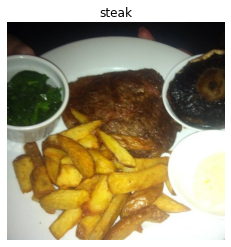

time: 109 ms (started: 2022-06-06 01:24:59 +05:30)


In [113]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="steak")

After going through a dozen or so images from the different classes, you can start to get an idea of what we're working with.

The entire Food101 dataset comprises of similar images from 101 different classes.

You might've noticed we've been printing the image shape alongside the plotted image.

This is because the way our computer sees the image is in the form of a big array (tensor).

In [114]:
# View the img (actually just a big array/tensor)
img

array([[[  3,   3,   5],
        [  3,   3,   5],
        [  3,   3,   5],
        ...,
        [  5,   5,   7],
        [  6,   6,   8],
        [  6,   6,   8]],

       [[  3,   3,   5],
        [  3,   3,   5],
        [  3,   3,   5],
        ...,
        [  5,   5,   7],
        [  5,   5,   7],
        [  6,   6,   8]],

       [[  3,   3,   5],
        [  3,   3,   5],
        [  3,   3,   5],
        ...,
        [  4,   4,   6],
        [  5,   5,   7],
        [  5,   5,   7]],

       ...,

       [[162, 168, 164],
        [164, 170, 166],
        [166, 172, 168],
        ...,
        [222, 230, 233],
        [213, 221, 224],
        [203, 211, 214]],

       [[160, 169, 164],
        [161, 170, 165],
        [163, 172, 167],
        ...,
        [214, 222, 225],
        [199, 206, 212],
        [184, 191, 197]],

       [[160, 169, 164],
        [161, 170, 165],
        [163, 172, 167],
        ...,
        [206, 214, 217],
        [187, 194, 200],
        [169, 176, 182]]

time: 3.63 ms (started: 2022-06-06 01:24:59 +05:30)


In [115]:
# View the image shape
img.shape # returns (width, height, colour channels)

(512, 512, 3)

time: 3.62 ms (started: 2022-06-06 01:24:59 +05:30)


Looking at the image shape more closely, you'll see it's in the form `(Width, Height, Colour Channels)`.

In our case, the width and height vary but because we're dealing with colour images, the colour channels value is always 3. This is for different values of [red, green and blue (RGB) pixels](https://en.wikipedia.org/wiki/RGB_color_model).

You'll notice all of the values in the `img` array are between 0 and 255. This is because that's the possible range for red, green and blue values.

For example, a pixel with a value `red=0, green=0, blue=255` will look very blue.

So when we build a model to differentiate between our images of `pizza` and `steak`, it will be finding patterns in these different pixel values which determine what each class looks like.

> 🔑 **Note:** As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to **scale** (also referred to as **normalize**) their pixel values by dividing the image arrays by 255.

In [116]:
# Get all the pixel values between 0 & 1
img/255. 

array([[[0.01176471, 0.01176471, 0.01960784],
        [0.01176471, 0.01176471, 0.01960784],
        [0.01176471, 0.01176471, 0.01960784],
        ...,
        [0.01960784, 0.01960784, 0.02745098],
        [0.02352941, 0.02352941, 0.03137255],
        [0.02352941, 0.02352941, 0.03137255]],

       [[0.01176471, 0.01176471, 0.01960784],
        [0.01176471, 0.01176471, 0.01960784],
        [0.01176471, 0.01176471, 0.01960784],
        ...,
        [0.01960784, 0.01960784, 0.02745098],
        [0.01960784, 0.01960784, 0.02745098],
        [0.02352941, 0.02352941, 0.03137255]],

       [[0.01176471, 0.01176471, 0.01960784],
        [0.01176471, 0.01176471, 0.01960784],
        [0.01176471, 0.01176471, 0.01960784],
        ...,
        [0.01568627, 0.01568627, 0.02352941],
        [0.01960784, 0.01960784, 0.02745098],
        [0.01960784, 0.01960784, 0.02745098]],

       ...,

       [[0.63529412, 0.65882353, 0.64313725],
        [0.64313725, 0.66666667, 0.65098039],
        [0.65098039, 0

time: 5.16 ms (started: 2022-06-06 01:24:59 +05:30)


## A (typical) architecture of a convolutional neural network

Convolutional neural networks are no different to other kinds of deep learning neural networks in the fact they can be created in many different ways. What you see below are some components you'd expect to find in a traditional CNN.


Components of a convolutional neural network:

| **Hyperparameter/Layer type** | **What does it do?** | **Typical values** |
| ----- | ----- | ----- |
| Input image(s) | Target images you'd like to discover patterns in| Whatever you can take a photo (or video) of |
| Input layer | Takes in target images and preprocesses them for further layers | `input_shape = [batch_size, image_height, image_width, color_channels]` |
| Convolution layer | Extracts/learns the most important features from target images | Multiple, can create with [`tf.keras.layers.ConvXD`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) (X can be multiple values) |
| Hidden activation | Adds non-linearity to learned features (non-straight lines) | Usually ReLU ([`tf.keras.activations.relu`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu)) |
| Pooling layer | Reduces the dimensionality of learned image features | Average ([`tf.keras.layers.AvgPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D)) or Max ([`tf.keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)) |
| Fully connected layer | Further refines learned features from convolution layers | [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) |
| Output layer | Takes learned features and outputs them in shape of target labels | `output_shape = [number_of_classes]` (e.g. 3 for pizza, steak or sushi)|
| Output activation | Adds non-linearities to output layer | [`tf.keras.activations.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid) (binary classification) or [`tf.keras.activations.softmax`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) |

How they stack together:

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-simple-convnet.png)
*A simple example of how you might stack together the above layers into a convolutional neural network. Note the convolutional and pooling layers can often be arranged and rearranged into many different formations.*

## An end-to-end example

We've checked out our data and found there's 750 training images, as well as 250 test images per class and they're all of various different shapes. 

It's time to jump straight in the deep end.

Reading the [original dataset authors paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf), we see they used a [Random Forest machine learning model](https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d) and averaged 50.76% accuracy at predicting what different foods different images had in them.

From now on, that 50.76% will be our baseline.

> 🔑 **Note:** A **baseline** is a score or evaluation metric you want to try and beat. Usually you'll start with a simple model, create a baseline and try to beat it by increasing the complexity of the model. A really fun way to learn machine learning is to find some kind of modelling paper with a published result and try to beat it.

The code in the following cell replicates and end-to-end way to model our `pizza_steak` dataset with a convolutional neural network (CNN) using the components listed above.

There will be a bunch of things you might not recognize but step through the code yourself and see if you can figure out what it's doing.

We'll go through each of the steps later on in the notebook.

For reference, the model we're using replicates TinyVGG, the computer vision architecture which fuels the [CNN explainer webpage](https://poloclub.github.io/cnn-explainer/).

> 📖 **Resource:** The architecture we're using below is a scaled-down version of [VGG-16](https://arxiv.org/abs/1505.06798), a convolutional neural network which came 2nd in the 2014 [ImageNet classification competition](http://image-net.org/).

In [117]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5


2022-06-06 01:25:00.092356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 0.5582 - accuracy: 0.7100

2022-06-06 01:25:06.272898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 8s 157ms/step - loss: 0.5582 - accuracy: 0.7100 - val_loss: 0.4493 - val_accuracy: 0.7780
Epoch 2/5
47/47 [==============================] - 7s 138ms/step - loss: 0.4267 - accuracy: 0.8040 - val_loss: 0.3624 - val_accuracy: 0.8420
Epoch 3/5
47/47 [==============================] - 6s 128ms/step - loss: 0.3897 - accuracy: 0.8287 - val_loss: 0.3337 - val_accuracy: 0.8700
Epoch 4/5
47/47 [==============================] - 7s 139ms/step - loss: 0.3558 - accuracy: 0.8467 - val_loss: 0.3331 - val_accuracy: 0.8640
Epoch 5/5
47/47 [==============================] - 7s 140ms/step - loss: 0.3223 - accuracy: 0.8700 - val_loss: 0.3123 - val_accuracy: 0.8700
time: 34.4 s (started: 2022-06-06 01:24:59 +05:30)


> 🤔 **Note:** If the cell above takes more than ~12 seconds per epoch to run, you might not be using a GPU accelerator. If you're using a Colab notebook, you can access a GPU accelerator by going to Runtime -> Change Runtime Type -> Hardware Accelerator and select "GPU". After doing so, you might have to rerun all of the above cells as changing the runtime type causes Colab to have to reset.





Nice! After 5 epochs, our model beat the baseline score of 50.76% accuracy (our model got ~85% accuaracy on the training set and ~85% accuracy on the test set).

However, our model only went through a binary classificaiton problem rather than all of the 101 classes in the Food101 dataset, so we can't directly compare these metrics. That being said, the results so far show that our model is learning something.

> 🛠 **Practice:** Step through each of the main blocks of code in the cell above, what do you think each is doing? It's okay if you're not sure, we'll go through this soon. In the meantime, spend 10-minutes playing around the incredible [CNN explainer website](https://poloclub.github.io/cnn-explainer/). What do you notice about the layer names at the top of the webpage?


Since we've already fit a model, let's check out its architecture.

In [118]:
# Check out the layers in our model
model_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_27 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 110, 110, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_29 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                

What do you notice about the names of `model_1`'s layers and the layer names at the top of the [CNN explainer website](https://poloclub.github.io/cnn-explainer/)?

I'll let you in on a little secret: we've replicated the exact architecture they use for their model demo.

Look at you go! **You're already starting to replicate models you find in the wild.**

Now there are a few new things here we haven't discussed, namely: 
* The [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class and the `rescale` parameter
* The [`flow_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory) method
  * The `batch_size` parameter
  * The `target_size` parameter
* [`Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers (and the parameters which come with them)
* [`MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers (and their parameters).
* The `steps_per_epoch` and `validation_steps` parameters in the `fit()` function

Before we dive into each of these, let's see what happens if we try to fit a model we've worked with previously to our data.


## Using the same model as before

To examplify how neural networks can be adapted to many different problems, let's see how a binary classification model we've previously built might work with our data.

> 🔑 **Note:** If you haven't gone through the previous classification notebook, no troubles, we'll be bringing in the a simple 4 layer architecture used to separate dots replicated from the [TensorFlow Playground environment](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=4,4&seed=0.75075&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false).

We can use all of the same parameters in our previous model except for changing two things:
* **The data** - we're now working with images instead of dots.
* **The input shape** - we have to tell our neural network the shape of the images we're working with.
  * A common practice is to reshape images all to one size. In our case, we'll resize the images to `(224, 224, 3)`, meaning a height and width of 224 pixels and a depth of 3 for the red, green, blue colour channels.

In [119]:
# Set random seed
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data, # use same training data created above
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data, # use same validation data created above
                        validation_steps=len(valid_data))

Epoch 1/5
 1/47 [..............................] - ETA: 16s - loss: 0.6756 - accuracy: 0.5625

2022-06-06 01:25:33.976434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 1.0600 - accuracy: 0.5040

2022-06-06 01:25:36.934751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 4s 81ms/step - loss: 1.0600 - accuracy: 0.5040 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 4s 91ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 5s 106ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 5s 106ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 10s 224ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
time: 29 s (started: 2022-06-06 01:25:33 +05:30)


Hmmm... our model ran but it doesn't seem like it learned anything. It only reaches 50% accuracy on the training and test sets which in a binary classification problem is as good as guessing.

Let's see the architecture.

In [120]:
# Check out our second model's architecture
model_2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 150528)            0         
                                                                 
 dense_16 (Dense)            (None, 4)                 602116    
                                                                 
 dense_17 (Dense)            (None, 4)                 20        
                                                                 
 dense_18 (Dense)            (None, 1)                 5         
                                                                 
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________
time: 13.2 ms (started: 2022-06-06 01:26:02 +05:30)


Wow. One of the most noticeable things here is the much larger number of parameters in `model_2` versus `model_1`.

`model_2` has 602,141 trainable parameters where as `model_1` has only 31,101. And despite this difference, `model_1` still far and large out performs `model_2`.

> 🔑 **Note:** You can think of trainable parameters as *patterns a model can learn from data*. Intuitiely, you might think more is better. And in some cases it is. But in this case, the difference here is in the two different styles of model we're using. Where a series of dense layers have a number of different learnable parameters connected to each other and hence a higher number of possible learnable patterns, **a convolutional neural network seeks to sort out and learn the most important patterns in an image**. So even though there are less learnable parameters in our convolutional neural network, these are often more helpful in decphering between different **features** in an image.

Since our previous model didn't work, do you have any ideas of how we might make it work?

How about we increase the number of layers? 

And maybe even increase the number of neurons in each layer?

More specifically, we'll increase the number of neurons (also called hidden units) in each dense layer from 4 to 100 and add an extra layer.

> 🔑 **Note:** Adding extra layers or increasing the number of neurons in each layer is often referred to as increasing the **complexity** of your model.

In [121]:
# Set random seed
tf.random.set_seed(42)

# Create a model similar to model_1 but add an extra layer and increase the number of hidden units in each layer
model_3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(100, activation='relu'), # increase number of neurons from 4 to 100 (for each layer)
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'), # add an extra layer
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5


2022-06-06 01:26:03.312132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 4.1903 - accuracy: 0.6213

2022-06-06 01:26:06.814764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 5s 94ms/step - loss: 4.1903 - accuracy: 0.6213 - val_loss: 0.6107 - val_accuracy: 0.7780
Epoch 2/5
47/47 [==============================] - 4s 89ms/step - loss: 1.2357 - accuracy: 0.6833 - val_loss: 0.9513 - val_accuracy: 0.6840
Epoch 3/5
47/47 [==============================] - 4s 90ms/step - loss: 1.4183 - accuracy: 0.6860 - val_loss: 0.5953 - val_accuracy: 0.8000
Epoch 4/5
47/47 [==============================] - 4s 89ms/step - loss: 0.5836 - accuracy: 0.7660 - val_loss: 0.8110 - val_accuracy: 0.6580
Epoch 5/5
47/47 [==============================] - 4s 89ms/step - loss: 0.5150 - accuracy: 0.7793 - val_loss: 0.4691 - val_accuracy: 0.7660
time: 22.2 s (started: 2022-06-06 01:26:02 +05:30)


Woah! Looks like our model is learning again. It got ~70% accuracy on the training set and ~70% accuracy on the validation set.

How does the architecute look?

In [122]:
# Check out model_3 architecture
model_3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 150528)            0         
                                                                 
 dense_19 (Dense)            (None, 100)               15052900  
                                                                 
 dense_20 (Dense)            (None, 100)               10100     
                                                                 
 dense_21 (Dense)            (None, 100)               10100     
                                                                 
 dense_22 (Dense)            (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________
time: 3.81 ms (started: 2022-06-06 01:26:

My gosh, the number of trainable parameters has increased even more than `model_2`. And even with close to 500x (~15,000,000 vs. ~31,000) more trainable parameters, `model_3` still doesn't out perform `model_1`.

This goes to show the power of convolutional neural networks and their ability to learn patterns despite using less parameters.

## Binary classification: Let's break it down

We just went through a whirlwind of steps:

1. Become one with the data (visualize, visualize, visualize...)
2. Preprocess the data (prepare it for a model)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve model (try to beat your baseline)
7. Repeat until satisfied

Let's step through each.

### 1. Import and become one with the data

Whatever kind of data you're dealing with, it's a good idea to visualize at least 10-100 samples to start to building your own mental model of the data.

In our case, we might notice that the steak images tend to have darker colours where as pizza images tend to have a distinct circular shape in the middle. These might be patterns that our neural network picks up on.

You an also notice if some of your data is messed up (for example, has the wrong label) and start to consider ways you might go about fixing it.

> 📖 **Resource:** To see how this data was processed into the file format we're using, see the [preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

If the visualization cell below doesn't work, make sure you've got the data by uncommenting the cell below.

In [123]:
# import zipfile

# # Download zip file of pizza_steak images
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# # Unzip the downloaded file
# zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
# zip_ref.extractall()
# zip_ref.close()

time: 153 µs (started: 2022-06-06 01:26:24 +05:30)


Image shape: (384, 512, 3)
Image shape: (512, 512, 3)


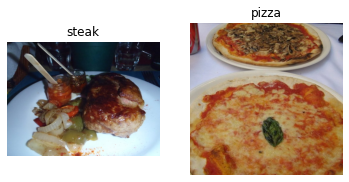

time: 87.2 ms (started: 2022-06-06 01:26:24 +05:30)


In [124]:
# Visualize data (requires function 'view_random_image' above)
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")

### 2. Preprocess the data (prepare it for a model)

One of the most important steps for a machine learning project is creating a training and test set.

In our case, our data is already split into training and test sets. Another option here might be to create a validation set as well, but we'll leave that for now.

For an image classification project, it's standard to have your data seperated into `train` and `test` directories with subfolders in each for each class.

To start we define the training and test directory paths.

In [125]:
# Define training and test directory paths
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

time: 260 µs (started: 2022-06-06 01:26:24 +05:30)


Our next step is to turn our data into **batches**.

A **batch** is a small subset of the dataset a model looks at during training. For example, rather than looking at 10,000 images at one time and trying to figure out the patterns, a model might only look at 32 images at a time.

It does this for a couple of reasons:
* 10,000 images (or more) might not fit into the memory of your processor (GPU).
* Trying to learn the patterns in 10,000 images in one hit could result in the model not being able to learn very well.

Why 32?

A [batch size of 32 is good for your health](https://twitter.com/ylecun/status/989610208497360896?s=20). 

No seriously, there are many different batch sizes you could use but 32 has proven to be very effective in many different use cases and is often the default for many data preprocessing functions.

To turn our data into batches, we'll first create an instance of [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) for each of our datasets.


In [126]:
# Create train and test data generators and rescale the data 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

time: 436 µs (started: 2022-06-06 01:26:24 +05:30)


The `ImageDataGenerator` class helps us prepare our images into batches as well as perform transformations on them as they get loaded into the model.

You might've noticed the `rescale` parameter. This is one example of the transformations we're doing.

Remember from before how we imported an image and it's pixel values were between 0 and 255?

The `rescale` parameter, along with `1/255.` is like saying "divide all of the pixel values by 255". This results in all of the image being imported and their pixel values being normalized (converted to be between 0 and 1).

> 🔑 **Note:** For more transformation options such as data augmentation (we'll see this later), refer to the [`ImageDataGenerator` documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

Now we've got a couple of ImageDataGenerator instances, we can load our images from their respective directories using the [`flow_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory) method.

In [127]:
# Turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
time: 74.4 ms (started: 2022-06-06 01:26:24 +05:30)


Wonderful! Looks like our training dataset has 1500 images belonging to 2 classes (pizza and steak) and our test dataset has 500 images also belonging to 2 classes.

Some things to here:
* Due to how our directories are structured, the classes get inferred by the subdirectory names in `train_dir` and `test_dir`.
* The `target_size` parameter defines the input size of our images in `(height, width)` format.
* The `class_mode` value of `'binary'` defines our classification problem type. If we had more than two classes, we would use `'categorical'`.
* The `batch_size` defines how many images will be in each batch, we've used 32 which is the same as the default.

We can take a look at our batched images and labels by inspecting the `train_data` object.

In [128]:
# Get a sample of the training data batch 
images, labels = train_data.next() # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

time: 96 ms (started: 2022-06-06 01:26:25 +05:30)


Wonderful, it seems our images and labels are in batches of 32.

Let's see what the images look like.

In [129]:
# Get the first two images
images[:2], images[0].shape

(array([[[[0.47058827, 0.40784317, 0.34509805],
          [0.48627454, 0.42352945, 0.36078432],
          [0.48627454, 0.43529415, 0.37254903],
          ...,
          [0.82745105, 0.7137255 , 0.48627454],
          [0.8431373 , 0.7372549 , 0.5294118 ],
          [0.87843144, 0.77647066, 0.58431375]],
 
         [[0.50980395, 0.427451  , 0.36078432],
          [0.5058824 , 0.42352945, 0.35686275],
          [0.5137255 , 0.4431373 , 0.3647059 ],
          ...,
          [0.82745105, 0.7058824 , 0.48235297],
          [0.82745105, 0.70980394, 0.49803925],
          [0.8431373 , 0.73333335, 0.5372549 ]],
 
         [[0.5254902 , 0.427451  , 0.34901962],
          [0.5372549 , 0.43921572, 0.36078432],
          [0.5372549 , 0.45098042, 0.36078432],
          ...,
          [0.82745105, 0.7019608 , 0.4784314 ],
          [0.82745105, 0.7058824 , 0.4901961 ],
          [0.8352942 , 0.7176471 , 0.5137255 ]],
 
         ...,
 
         [[0.77647066, 0.5647059 , 0.2901961 ],
          [0.77647

time: 3.12 ms (started: 2022-06-06 01:26:25 +05:30)


Due to our `rescale` parameter, the images are now in `(224, 224, 3)` shape tensors with values between 0 and 1.

How about the labels?

In [130]:
# View the first batch of labels
labels

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

time: 1.72 ms (started: 2022-06-06 01:26:25 +05:30)


Due to the `class_mode` parameter being `'binary'` our labels are either `0` (pizza) or `1` (steak).

Now that our data is ready, our model is going to try and figure out the patterns between the image tensors and the labels.

### 3. Create a model (start with a baseline)

A baseline is a relatively simple model or existing result that you setup when beginning a machine learning experiment and then as you keep experimenting, you try to beat the baseline.

> 🔑 **Note:** In deep learning there is almost an infinite amount of architectures you could create. So one of the best ways to get started is to start with something simple and see if it works on your data and then introduce complexity as required (e.g. look at which current model is performung best in the field for your problem).

You might be wondering what your default model architecture should be.

And the truth is, there's many possible answers to this question.

A simple heuristic for computer vision models is to use the model architecture which is performing best on [ImageNet](https://www.image-net.org/) (a large collection of diverse images to benchmark different computer vision models).

However, to begin with, it's good to build a smaller model to acquire a baseline result which you try to improve upon.

> 🔑 **Note:** In deep learning a smaller model often refers to a model with less layers than the state of the art (SOTA). For example, a smaller model might have 3-4 layers where as a state of the art model, such as, ResNet50 might have 50+ layers.

In our case, let's take a smaller version of the model that can be found on the [CNN explainer website](https://poloclub.github.io/cnn-explainer/) (`model_1` from above) and build a 3 layer convolutional neural network.

In [131]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

time: 352 µs (started: 2022-06-06 01:26:25 +05:30)


In [132]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_4 = Sequential([
  Conv2D(filters=10, 
         kernel_size=3, 
         strides=1,
         padding='valid',
         activation='relu', 
         input_shape=(224, 224, 3)), # input layer (specify input shape)
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(1, activation='sigmoid') # output layer (specify output shape)
])

time: 48.9 ms (started: 2022-06-06 01:26:25 +05:30)


Great! We've got a simple convolutional neural network architecture ready to go.

And it follows the typical CNN structure of:

```
Input -> Conv + ReLU layers (non-linearities) -> Pooling layer -> Fully connected (dense layer) as Output
```

Let's discuss some of the components of the `Conv2D` layer:

* The "`2D`" means our inputs are two dimensional (height and width), even though they have 3 colour channels, the convolutions are run on each channel invididually.
* `filters` - these are the number of "feature extractors" that will be moving over our images.
* `kernel_size` - the size of our filters, for example, a `kernel_size` of `(3, 3)` (or just 3) will mean each filter will have the size 3x3, meaning it will look at a space of 3x3 pixels each time. The smaller the kernel, the more fine-grained features it will extract.
* `stride` - the number of pixels a `filter` will move across as it covers the image. A `stride` of 1 means the filter moves across each pixel 1 by 1. A `stride` of 2 means it moves 2 pixels at a time.
* `padding` - this can be either `'same'` or `'valid'`, `'same'` adds zeros the to outside of the image so the resulting output of the convolutional layer is the same as the input, where as `'valid'` (default) cuts off excess pixels where the `filter` doesn't fit (e.g. 224 pixels wide divided by a kernel size of 3 (224/3 = 74.6) means a single pixel will get cut off the end.

What's a "feature"?

A **feature** can be considered any significant part of an image. For example, in our case, a feature might be the circular shape of pizza. Or the rough edges on the outside of a steak.

It's important to note that these **features** are not defined by us, instead, the model learns them as it applies different filters across the image.

> 📖 **Resources:** For a great demonstration of these in action, be sure to spend some time going through the following:
  * [CNN Explainer Webpage](https://poloclub.github.io/cnn-explainer/) - a great visual overview of many of the concepts we're replicating here with code.
  * [A guide to convolutional arithmetic for deep learning](https://arxiv.org/pdf/1603.07285.pdf) - a phenomenal introduction to the math going on behind the scenes of a convolutional neural network.
  * For a great explanation of padding, see this [Stack Overflow answer](https://stackoverflow.com/a/39371113/7900723).

Now our model is ready, let's compile it.

In [133]:
# Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

time: 3.18 ms (started: 2022-06-06 01:26:25 +05:30)


Since we're working on a binary classification problem (pizza vs. steak), the `loss` function we're using is `'binary_crossentropy'`, if it was mult-iclass, we might use something like `'categorical_crossentropy'`.

Adam with all the default settings is our optimizer and our evaluation metric is accuracy.

### 4. Fit a model

Our model is compiled, time to fit it.

You'll notice two new parameters here:
* `steps_per_epoch` - this is the number of batches a model will go through per epoch, in our case, we want our model to go through all batches so it's equal to the length of `train_data` (1500 images in batches of 32 = 1500/32 = ~47 steps)
* `validation_steps` - same as above, except for the `validation_data` parameter (500 test images in batches of 32 = 500/32 = ~16 steps)

In [134]:
# Check lengths of training and test data generators
len(train_data), len(test_data)

(47, 16)

time: 1.19 ms (started: 2022-06-06 01:26:25 +05:30)


In [135]:
# Fit the model
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data), 
                        callbacks=[tensorboard_callback])

Epoch 1/5


2022-06-06 01:26:25.549072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 0.9770 - accuracy: 0.7027

2022-06-06 01:26:30.772613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 7s 136ms/step - loss: 0.9770 - accuracy: 0.7027 - val_loss: 0.4373 - val_accuracy: 0.8140
Epoch 2/5
47/47 [==============================] - 6s 128ms/step - loss: 0.4349 - accuracy: 0.8173 - val_loss: 0.3944 - val_accuracy: 0.8400
Epoch 3/5
47/47 [==============================] - 6s 126ms/step - loss: 0.3195 - accuracy: 0.8767 - val_loss: 0.4556 - val_accuracy: 0.7860
Epoch 4/5
47/47 [==============================] - 6s 127ms/step - loss: 0.1753 - accuracy: 0.9433 - val_loss: 0.5025 - val_accuracy: 0.8040
Epoch 5/5
47/47 [==============================] - 6s 129ms/step - loss: 0.0479 - accuracy: 0.9873 - val_loss: 0.5623 - val_accuracy: 0.7860
time: 31 s (started: 2022-06-06 01:26:25 +05:30)


### 5. Evaluate the model

Oh yeah! Looks like our model is learning something.

Let's check out its training curves.

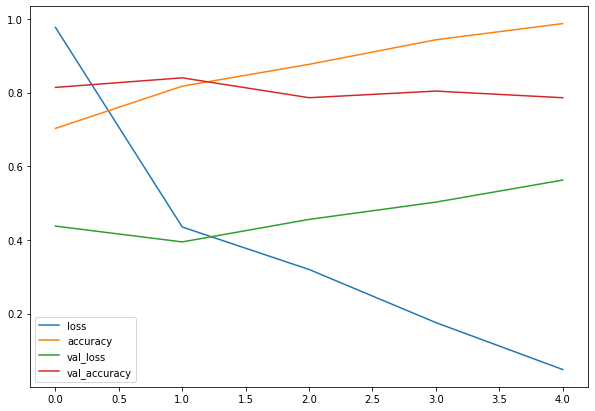

time: 74.5 ms (started: 2022-06-06 01:26:56 +05:30)


In [136]:
# Plot the training curves
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7));

Hmm, judging by our loss curves, it looks like our model is **overfitting** the training dataset.

> 🔑 **Note:** When a model's **validation loss starts to increase**, it's likely that it's overfitting the training dataset. This means, it's learning the patterns in the training dataset *too well* and thus its ability to generalize to unseen data will be diminished.

To further inspect our model's training performance, let's separate the accuracy and loss curves.

In [137]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

time: 610 µs (started: 2022-06-06 01:26:56 +05:30)


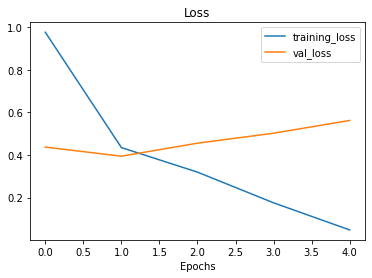

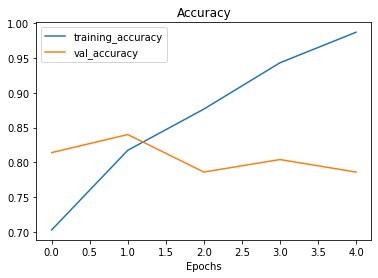

time: 154 ms (started: 2022-06-06 01:26:56 +05:30)


In [138]:
# Check out the loss curves of model_4
plot_loss_curves(history_4)

The ideal position for these two curves is to follow each other. If anything, the validation curve should be slightly under the training curve. If there's a large gap between the training curve and validation curve, it means your model is probably overfitting.

In [139]:
# Check out our model's architecture
model_4.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_31 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 conv2d_32 (Conv2D)          (None, 218, 218, 10)      910       
                                                                 
 flatten_13 (Flatten)        (None, 475240)            0         
                                                                 
 dense_23 (Dense)            (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________
time: 11.1 ms (started: 2022-06-06 01:26:56 +05

### 6. Adjust the model parameters

Fitting a machine learning model  comes in 3 steps:
0. Create a basline.
1. Beat the baseline by overfitting a larger model.
2. Reduce overfitting.

So far we've gone through steps 0 and 1.

And there are even a few more things we could try to further overfit our model:
* Increase the number of convolutional layers.
* Increase the number of convolutional filters.
* Add another dense layer to the output of our flattened layer.

But what we'll do instead is focus on getting our model's training curves to better align with eachother, in other words, we'll take on step 2.

Why is reducing overfitting important?

When a model performs too well on training data and poorly on unseen data, it's not much use to us if we wanted to use it in the real world.

Say we were building a pizza vs. steak food classifier app, and our model performs very well on our training data but when users tried it out, they didn't get very good results on their own food images, is that a good experience?

Not really...

So for the next few models we build, we're going to adjust a number of parameters and inspect the training curves along the way.

Namely, we'll build 2 more models:
* A ConvNet with [max pooling](https://deeplizard.com/learn/video/ZjM_XQa5s6s)
* A ConvNet with max pooling and data augmentation

For the first model, we'll follow the modified basic CNN structure:

```
Input -> Conv layers + ReLU layers (non-linearities) + Max Pooling layers -> Fully connected (dense layer) as Output
```

Let's built it. It'll have the same structure as `model_4` but with a [`MaxPool2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layer after each convolutional layer.

In [140]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_5 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

time: 63.5 ms (started: 2022-06-06 01:26:56 +05:30)


Woah, we've got another layer type we haven't seen before.

If convolutional layers learn the features of an image you can think of a Max Pooling layer as figuring out the *most important* of those features. We'll see this an example of this in a moment.

In [141]:
# Compile model (same as model_4)
model_5.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

time: 5.31 ms (started: 2022-06-06 01:26:56 +05:30)


In [142]:
# Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5


2022-06-06 01:26:57.042555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 0.6260 - accuracy: 0.6340

2022-06-06 01:27:00.582525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 5s 101ms/step - loss: 0.6260 - accuracy: 0.6340 - val_loss: 0.4630 - val_accuracy: 0.7960
Epoch 2/5
47/47 [==============================] - 4s 92ms/step - loss: 0.4762 - accuracy: 0.7927 - val_loss: 0.3868 - val_accuracy: 0.8420
Epoch 3/5
47/47 [==============================] - 4s 94ms/step - loss: 0.4534 - accuracy: 0.7827 - val_loss: 0.4167 - val_accuracy: 0.8240
Epoch 4/5
47/47 [==============================] - 4s 92ms/step - loss: 0.4077 - accuracy: 0.8207 - val_loss: 0.3720 - val_accuracy: 0.8520
Epoch 5/5
47/47 [==============================] - 4s 92ms/step - loss: 0.3721 - accuracy: 0.8420 - val_loss: 0.3545 - val_accuracy: 0.8520
time: 23 s (started: 2022-06-06 01:26:56 +05:30)


Okay, it looks like our model with max pooling (`model_5`) is performing worse on the training set but better on the validation set.

Before we checkout its training curves, let's check out its architecture.

In [143]:
# Check out the model architecture
model_5.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 111, 111, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 54, 54, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 26, 26, 10)     

Do you notice what's going on here with the output shape in each `MaxPooling2D` layer?

It gets halved each time. This is effectively the `MaxPooling2D` layer taking the outputs of each Conv2D layer and saying "I only want the most important features, get rid of the rest".

The bigger the `pool_size` parameter, the more the max pooling layer will squeeze the features out of the image. However, too big and the model might not be able to learn anything.

The results of this pooling are seen in a major reduction of total trainable parameters (8,861 in `model_5` and 477,431 in `model_4`).

Time to check out the loss curves.

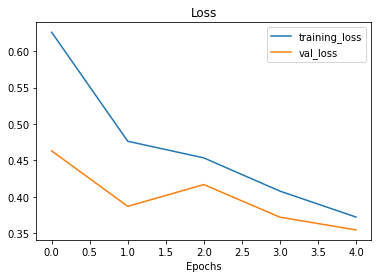

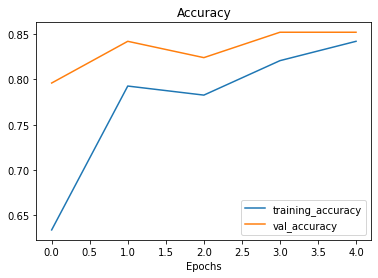

time: 366 ms (started: 2022-06-06 01:27:19 +05:30)


In [144]:
# Plot loss curves of model_5 results
plot_loss_curves(history_5)

Nice! We can see the training curves get a lot closer to eachother. However, our the validation loss looks to start increasing towards the end and in turn potentially leading to overfitting.

Time to dig into our bag of tricks and try another method of overfitting prevention, data augmentation.

First, we'll see how it's done with code then we'll discuss what it's doing.

To implement data augmentation, we'll have to reinstantiate our [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) instances.

In [145]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.) 

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

time: 849 µs (started: 2022-06-06 01:27:19 +05:30)


> 🤔 **Question:** What's data augmentation?

**Data augmentation** is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar.

Doing this simulates the kind of data a model might be used on in the real world.

If we're building a pizza vs. steak application, not all of the images our users take might be in similar setups to our training data. Using data augmentation gives us another way to prevent overfitting and in turn make our model more generalizable.

> 🔑 **Note:** Data augmentation is usally only performed on the training data. Using the `ImageDataGenerator` built-in data augmentation parameters our images are left as they are in the directories but are randomly manipulated when loaded into the model.

In [146]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images:
Found 1500 images belonging to 2 classes.
Non-augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.
time: 147 ms (started: 2022-06-06 01:27:19 +05:30)


Better than talk about data augmentation, how about we see it?

(remember our motto? visualize, visualize, visualize...)

In [147]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

time: 346 ms (started: 2022-06-06 01:27:20 +05:30)


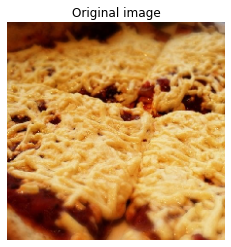

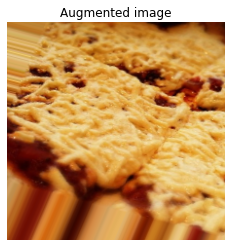

time: 100 ms (started: 2022-06-06 01:27:20 +05:30)


In [148]:
# Show original image and augmented image
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

After going through a sample of original and augmented images, you can start to see some of the example transformations on the training images.

Notice how some of the augmented images look like slightly warped versions of the original image. This means our model will be forced to try and learn patterns in less-than-perfect images, which is often the case when using real-world images.

> 🤔 **Question:** Should I use data augmentation? And how much should I augment?

Data augmentation is a way to try and prevent a model overfitting. If your model is overfiting (e.g. the validation loss keeps increasing), you may want to try using data augmentation.

As for how much to data augment, there's no set practice for this. Best to check out the options in the `ImageDataGenerator` class and think about how a model in your use case might benefit from some data augmentation.

Now we've got augmented data, let's try and refit a model on it and see how it affects training.

We'll use the same model as `model_5`.

In [149]:
# Create the model (same as model_5)
model_6 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_6 = model_6.fit(train_data_augmented, # changed to augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5


2022-06-06 01:27:21.086738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 0.7015 - accuracy: 0.5087

2022-06-06 01:27:29.919728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 10s 205ms/step - loss: 0.7015 - accuracy: 0.5087 - val_loss: 0.6814 - val_accuracy: 0.6640
Epoch 2/5
47/47 [==============================] - 10s 204ms/step - loss: 0.6926 - accuracy: 0.5273 - val_loss: 0.6619 - val_accuracy: 0.7440
Epoch 3/5
47/47 [==============================] - 10s 204ms/step - loss: 0.6906 - accuracy: 0.5933 - val_loss: 0.6279 - val_accuracy: 0.7760
Epoch 4/5
47/47 [==============================] - 10s 203ms/step - loss: 0.6681 - accuracy: 0.5833 - val_loss: 0.5848 - val_accuracy: 0.7580
Epoch 5/5
47/47 [==============================] - 10s 205ms/step - loss: 0.6344 - accuracy: 0.6640 - val_loss: 0.5080 - val_accuracy: 0.8020
time: 48.8 s (started: 2022-06-06 01:27:20 +05:30)


> 🤔 **Question:** Why didn't our model get very good results on the training set to begin with?

It's because when we created `train_data_augmented` we turned off data shuffling using `shuffle=False` which means our model only sees a batch of a single kind of images at a time. 

For example, the pizza class gets loaded in first because it's the first class. Thus it's performance is measured on only a single class rather than both classes. The validation data performance improves steadily because it contains shuffled data.

Since we only set `shuffle=False` for demonstration purposes (so we could plot the same augmented and non-augmented image), we can fix this by setting `shuffle=True` on future data generators.

You may have also noticed each epoch taking longer when training with augmented data compared to when training with non-augmented data (~25s per epoch vs. ~10s per epoch).

This is because the `ImageDataGenerator` instance augments the data as it's loaded into the model. The benefit of this is that it leaves the original images unchanged. The downside is that it takes longer to load them in.

> 🔑 **Note:** One possible method to speed up dataset manipulation would be to look into [TensorFlow's parrallel reads and buffered prefecting options](https://www.tensorflow.org/tutorials/images/data_augmentation).

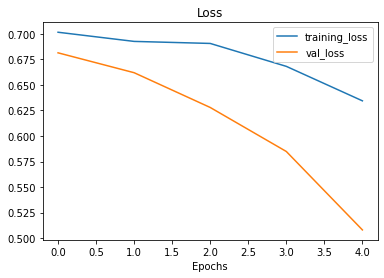

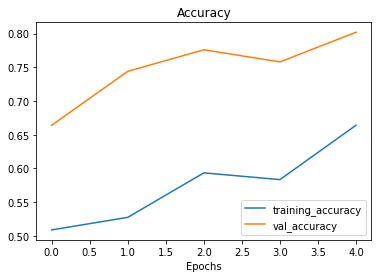

time: 108 ms (started: 2022-06-06 01:28:09 +05:30)


In [150]:
# Check model's performance history training on augmented data
plot_loss_curves(history_6)

It seems our validation loss curve is heading in the right direction but it's a bit jumpy (the most ideal loss curve isn't too spiky but a smooth descent, however, a perfectly smooth loss curve is the equivalent of a fairytale).

Let's see what happens when we shuffle the augmented training data.

In [151]:
# Import data and augment it from directories
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='binary',
                                                                            shuffle=True) # Shuffle data (default)

Found 1500 images belonging to 2 classes.
time: 43.2 ms (started: 2022-06-06 01:28:09 +05:30)


In [152]:
# Create the model (same as model_5 and model_6)
model_7 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_7 = model_7.fit(train_data_augmented_shuffled, # now the augmented data is shuffled
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5


2022-06-06 01:28:09.946794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 0.6202 - accuracy: 0.6373

2022-06-06 01:28:18.882084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 10s 207ms/step - loss: 0.6202 - accuracy: 0.6373 - val_loss: 0.4426 - val_accuracy: 0.8320
Epoch 2/5
47/47 [==============================] - 10s 204ms/step - loss: 0.5130 - accuracy: 0.7527 - val_loss: 0.3558 - val_accuracy: 0.8520
Epoch 3/5
47/47 [==============================] - 10s 205ms/step - loss: 0.4717 - accuracy: 0.7833 - val_loss: 0.3947 - val_accuracy: 0.8180
Epoch 4/5
47/47 [==============================] - 10s 205ms/step - loss: 0.4549 - accuracy: 0.7940 - val_loss: 0.3467 - val_accuracy: 0.8640
Epoch 5/5
47/47 [==============================] - 10s 205ms/step - loss: 0.4406 - accuracy: 0.7993 - val_loss: 0.3477 - val_accuracy: 0.8560
time: 49 s (started: 2022-06-06 01:28:09 +05:30)


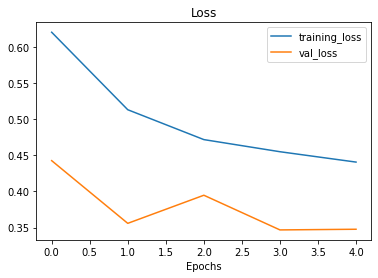

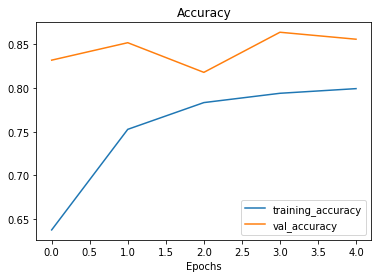

time: 100 ms (started: 2022-06-06 01:28:58 +05:30)


In [153]:
# Check model's performance history training on augmented data
plot_loss_curves(history_7)

Notice with `model_7` how the performance on the training dataset improves almost immediately compared to `model_6`. This is because we shuffled the training data as we passed it to the model using the parameter `shuffle=True` in the `flow_from_directory` method.

This means the model was able to see examples of both pizza and steak images in each batch and in turn be evaluated on what it learned from both images rather than just one kind.

Also, our loss curves look a little bit smoother with shuffled data (comparing `history_6` to `history_7`).

### 7. Repeat until satisified

We've trained a few model's on our dataset already and so far they're performing pretty good.

Since we've already beaten our baseline, there are a few things we could try to continue to improve our model:
* Increase the number of model layers (e.g. add more convolutional layers).
* Increase the number of filters in each convolutional layer (e.g. from 10 to 32, 64, or 128, these numbers aren't set in stone either, they are usually found through trial and error).
* Train for longer (more epochs).
* Finding an ideal learning rate.
* Get more data (give the model more opportunities to learn).
* Use **transfer learning** to leverage what another image model has learned and adjust it for our own use case.

Adjusting each of these settings (except for the last two) during model development is usually referred to as **hyperparameter tuning**.

You can think of hyperparameter tuning as simialr to adjusting the settings on your oven to cook your favourite dish. Although your oven does most of the cooking for you, you can help it by tweaking the dials.

Let's go back to right where we started and try our original model (`model_1` or the TinyVGG architecture from [CNN explainer](https://poloclub.github.io/cnn-explainer/)).


In [154]:
# Create a CNN model (same as Tiny VGG but for binary classification - https://poloclub.github.io/cnn-explainer/ )
model_8 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)), # same input shape as our images
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_8.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_8 = model_8.fit(train_data_augmented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5


2022-06-06 01:28:59.037321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 0.6492 - accuracy: 0.6100

2022-06-06 01:29:08.041375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 10s 212ms/step - loss: 0.6492 - accuracy: 0.6100 - val_loss: 0.5364 - val_accuracy: 0.7100
Epoch 2/5
47/47 [==============================] - 10s 208ms/step - loss: 0.5328 - accuracy: 0.7493 - val_loss: 0.3904 - val_accuracy: 0.8320
Epoch 3/5
47/47 [==============================] - 10s 205ms/step - loss: 0.5278 - accuracy: 0.7447 - val_loss: 0.4233 - val_accuracy: 0.8240
Epoch 4/5
47/47 [==============================] - 10s 206ms/step - loss: 0.5086 - accuracy: 0.7660 - val_loss: 0.4054 - val_accuracy: 0.8580
Epoch 5/5
47/47 [==============================] - 10s 206ms/step - loss: 0.4851 - accuracy: 0.7740 - val_loss: 0.4104 - val_accuracy: 0.8220
time: 49.6 s (started: 2022-06-06 01:28:58 +05:30)


> 🔑 **Note:** You might've noticed we used some slightly different code to build `model_8` as compared to `model_1`. This is because of the imports we did before, such as `from tensorflow.keras.layers import Conv2D` reduce the amount of code we had to write. Although the code is different, the architectures are the same.

In [155]:
# Check model_1 architecture (same as model_8)
model_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_27 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 110, 110, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_29 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                

In [156]:
# Check model_8 architecture (same as model_1)
model_8.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_43 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 110, 110, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_45 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                

Now let's check out our TinyVGG model's performance.

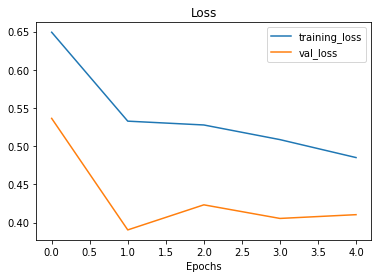

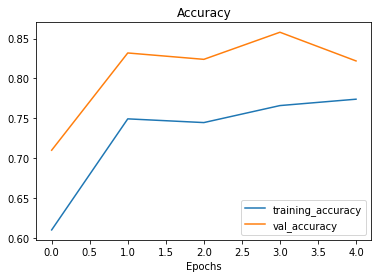

time: 114 ms (started: 2022-06-06 01:29:48 +05:30)


In [157]:
# Check out the TinyVGG model performance
plot_loss_curves(history_8)

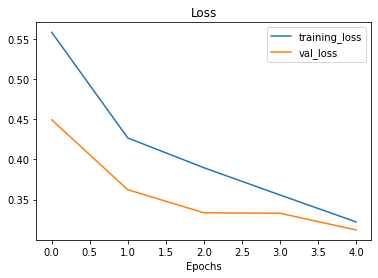

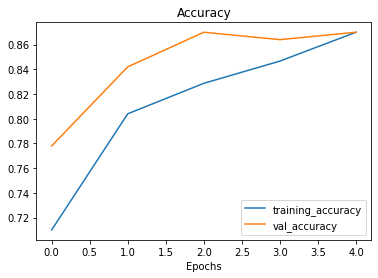

time: 120 ms (started: 2022-06-06 01:29:48 +05:30)


In [158]:
# How does this training curve look compared to the one above?
plot_loss_curves(history_1)

Hmm, our training curves are looking good, but our model's performance on the training and test sets didn't improve much compared to the previous model.

Taking another loook at the training curves, it looks like our model's performance might improve if we trained it a little longer (more epochs).

Perhaps that's something you like to try?

### Making a prediction with our trained model

What good is a trained model if you can't make predictions with it?

To really test it out, we'll upload a couple of our own images and see how the model goes.

First, let's remind ourselves of the classnames and view the image we're going to test on.

In [159]:
# Classes we're working with
print(class_names)

['pizza' 'steak']
time: 245 µs (started: 2022-06-06 01:29:48 +05:30)


The first test image we're going to use is [a delicious steak](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg) I cooked the other day.

--2022-06-06 01:29:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg’

03-steak.jpeg       100%[===================>]   1.89M  10.7MB/s    in 0.2s    

2022-06-06 01:29:49 (10.7 MB/s) - ‘03-steak.jpeg’ saved [1978213/1978213]



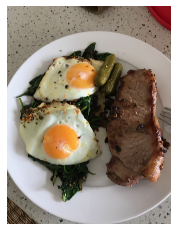

time: 2.41 s (started: 2022-06-06 01:29:48 +05:30)


In [160]:
# View our example image
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg 
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);

In [161]:
# Check the shape of our image
steak.shape

(4032, 3024, 3)

time: 2.73 ms (started: 2022-06-06 01:29:50 +05:30)


Since our model takes in images of shapes `(224, 224, 3)`, we've got to reshape our custom image to use it with our model.

To do so, we can import and decode our image using [`tf.io.read_file`](https://www.tensorflow.org/api_docs/python/tf/io/read_file) (for readining files) and [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image) (for resizing our image and turning it into a tensor).

> 🔑 **Note:** For your model to make predictions on unseen data, for example, your own custom images, the custom image has to be in the same shape as your model has been trained on. In more general terms, to make predictions on custom data it has to be in the same form that your model has been trained on.

In [162]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

time: 533 µs (started: 2022-06-06 01:29:50 +05:30)


Now we've got a function to load our custom image, let's load it in.

In [163]:
# Load in and preprocess our custom image
steak = load_and_prep_image("03-steak.jpeg")
steak

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.63774514, 0.62205887, 0.5789216 ],
        [0.6504902 , 0.63186276, 0.58970594],
        [0.63186276, 0.60833335, 0.5612745 ],
        ...,
        [0.52156866, 0.0509804 , 0.09019608],
        [0.49509805, 0.04215686, 0.07058824],
        [0.5284314 , 0.07745098, 0.10490197]],

       [[0.66176474, 0.64607847, 0.61078435],
        [0.6387255 , 0.62303925, 0.5759804 ],
        [0.6558824 , 0.632353  , 0.5852941 ],
        ...,
        [0.5352942 , 0.06862745, 0.09215686],
        [0.529902  , 0.05931373, 0.09460785],
        [0.5142157 , 0.05539216, 0.08676471]],

       [[0.65196085, 0.6362746 , 0.5892157 ],
        [0.6392157 , 0.61372554, 0.5676471 ],
        [0.6563726 , 0.6269608 , 0.5828432 ],
        ...,
        [0.5313726 , 0.06470589, 0.08039216],
        [0.52745104, 0.06862745, 0.10000001],
        [0.52254903, 0.05196079, 0.0872549 ]],

       ...,

       [[0.49313727, 0.427451  , 0.31029412],
        [0.05

time: 109 ms (started: 2022-06-06 01:29:50 +05:30)


Wonderful, our image is in tensor format, time to try it with our model!

In [164]:
# Make a prediction on our custom image (spoiler: this won't work)
model_8.predict(tf.expand_dims(steak, axis=0))

2022-06-06 01:29:51.037957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[0.8912291]], dtype=float32)

time: 86 ms (started: 2022-06-06 01:29:50 +05:30)


There's one more problem...

Although our image is in the same shape as the images our model has been trained on, we're still missing a dimension.

Remember how our model was trained in batches?

Well, the batch size becomes the first dimension.

So in reality, our model was trained on data in the shape of `(batch_size, 224, 224, 3)`.

We can fix this by adding an extra to our custom image tensor using [`tf.expand_dims`](https://www.tensorflow.org/api_docs/python/tf/expand_dims).

In [165]:
# Add an extra axis
print(f"Shape before new dimension: {steak.shape}")
steak = tf.expand_dims(steak, axis=0) # add an extra dimension at axis 0
#steak = steak[tf.newaxis, ...] # alternative to the above, '...' is short for 'every other dimension'
print(f"Shape after new dimension: {steak.shape}")
steak

Shape before new dimension: (224, 224, 3)
Shape after new dimension: (1, 224, 224, 3)


<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.63774514, 0.62205887, 0.5789216 ],
         [0.6504902 , 0.63186276, 0.58970594],
         [0.63186276, 0.60833335, 0.5612745 ],
         ...,
         [0.52156866, 0.0509804 , 0.09019608],
         [0.49509805, 0.04215686, 0.07058824],
         [0.5284314 , 0.07745098, 0.10490197]],

        [[0.66176474, 0.64607847, 0.61078435],
         [0.6387255 , 0.62303925, 0.5759804 ],
         [0.6558824 , 0.632353  , 0.5852941 ],
         ...,
         [0.5352942 , 0.06862745, 0.09215686],
         [0.529902  , 0.05931373, 0.09460785],
         [0.5142157 , 0.05539216, 0.08676471]],

        [[0.65196085, 0.6362746 , 0.5892157 ],
         [0.6392157 , 0.61372554, 0.5676471 ],
         [0.6563726 , 0.6269608 , 0.5828432 ],
         ...,
         [0.5313726 , 0.06470589, 0.08039216],
         [0.52745104, 0.06862745, 0.10000001],
         [0.52254903, 0.05196079, 0.0872549 ]],

        ...,

        [[0.49313727, 0.427451  , 

time: 2.54 ms (started: 2022-06-06 01:29:51 +05:30)


Our custom image has a batch size of 1! Let's make a prediction on it.

In [166]:
# Make a prediction on custom image tensor
pred = model_8.predict(steak)
pred

array([[0.8912291]], dtype=float32)

time: 24.7 ms (started: 2022-06-06 01:29:51 +05:30)


Ahh, the predictions come out in **prediction probability** form. In other words, this means how likely the image is to be one class or another.

Since we're working with a binary classification problem, if the prediction probability is over 0.5, according to the model, the prediction is most likely to be the **postive class** (class 1).

And if the prediction probability is under 0.5, according to the model, the predicted class is most likely to be the **negative class** (class 0).

> 🔑 **Note:** The 0.5 cutoff can be adjusted to your liking. For example, you could set the limit to be 0.8 and over for the positive class and 0.2 for the negative class. However, doing this will almost always change your model's performance metrics so be sure to make sure they change in the right direction.

But saying positive and negative class doesn't make much sense when we're working with pizza 🍕 and steak 🥩...

So let's write a little function to convert predictions into their class names and then plot the target image.

In [167]:
# Remind ourselves of our class names
class_names

array(['pizza', 'steak'], dtype='<U5')

time: 1.52 ms (started: 2022-06-06 01:29:51 +05:30)


In [168]:
# We can index the predicted class by rounding the prediction probability
pred_class = class_names[int(tf.round(pred)[0][0])]
pred_class

'steak'

time: 3.37 ms (started: 2022-06-06 01:29:51 +05:30)


In [169]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

time: 376 µs (started: 2022-06-06 01:29:51 +05:30)


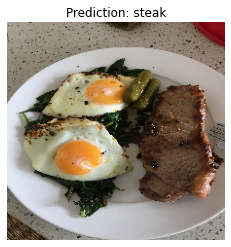

time: 154 ms (started: 2022-06-06 01:29:51 +05:30)


In [170]:
# Test our model on a custom image
pred_and_plot(model_8, "03-steak.jpeg", class_names)

Nice! Our model got the prediction right.

The only downside of working with food is this is making me hungry.

Let's try one more image.

--2022-06-06 01:29:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg’

03-pizza-dad.jpeg   100%[===================>]   2.74M  10.5MB/s    in 0.3s    

2022-06-06 01:29:54 (10.5 MB/s) - ‘03-pizza-dad.jpeg’ saved [2874848/2874848]



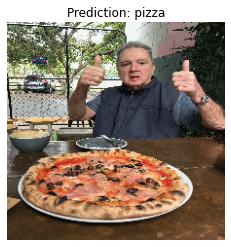

time: 3.86 s (started: 2022-06-06 01:29:51 +05:30)


In [171]:
# Download another test image and make a prediction on it
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg 
pred_and_plot(model_8, "03-pizza-dad.jpeg", class_names)

Two thumbs up! Woohoo!

## Multi-class Classification

We've referenced the TinyVGG architecture from the CNN Explainer website multiple times through this notebook, however, the CNN Explainer website works with 10 different image classes, where as our current model only works with two classes (pizza and steak).

> 🛠 **Practice:** Before scrolling down, how do you think we might change our model to work with 10 classes of the same kind of images? Assume the data is in the same style as our two class problem.

Remember the steps we took before to build our pizza 🍕 vs. steak 🥩 classifier?

How about we go through those steps again, except this time, we'll work with 10 different types of food.

1. Become one with the data (visualize, visualize, visualize...)
2. Preprocess the data (prepare it for a model)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve model (try to beat your baseline)
7. Repeat until satisfied

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/misc-tensorflow-workflow-outline.png)
*The workflow we're about to go through is a slightly modified version of the above image. As you keep going through deep learning problems, you'll find the workflow above is more of an outline than a step-by-step guide.*

### 1. Import and become one with the data

Again, we've got a subset of the [Food101 dataset](https://www.kaggle.com/dansbecker/food-101). In addition to the pizza and steak images, we've pulled out another eight classes.


In [172]:
import zipfile
import os

# Download zip file of 10_food_classes images
# See how this data was created - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
if "10_food_classes_all_data.zip" not in os.listdir():
  !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
else:
  print(f"10_food_classes_all_data.zip already downloaded")

if "10_food_classes_all_data.zip" in os.listdir() and not os.path.isdir("10_food_classes_all_data"):
  # Unzip the downloaded file
  zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
  zip_ref.extractall()
  zip_ref.close()
else:
  print("Zip file already extracted in to the folder '10_food_classes_all_data'")

--2022-06-06 01:29:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4009:81c::2010, 2404:6800:4009:80e::2010, 2404:6800:4009:814::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4009:81c::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  15.5MB/s    in 31s     

2022-06-06 01:30:27 (15.8 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]

time: 35.2 s (started: 2022-06-06 01:29:55 +05:30)


Now let's check out all of the different directories and sub-directories in the `10_food_classes` file.

In [173]:
# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  filenames = [f for f in filenames if not f.startswith('.')]
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 

Looking good!

We'll now setup the training and test directory paths.

In [174]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

time: 236 µs (started: 2022-06-06 01:30:30 +05:30)


And get the class names from the subdirectories.

In [175]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']
time: 1.31 ms (started: 2022-06-06 01:30:30 +05:30)


How about we visualize an image from the training set?

Image shape: (512, 512, 3)


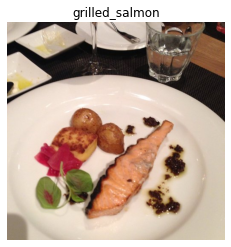

time: 135 ms (started: 2022-06-06 01:30:30 +05:30)


In [176]:
# View a random image from the training dataset
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names)) # get a random class name

### 2. Preprocess the data (prepare it for a model)

After going through a handful of images (it's good to visualize at least 10-100 different examples), it looks like our data directories are setup correctly.

Time to preprocess the data.

In [177]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical') # changed to categorical

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
time: 336 ms (started: 2022-06-06 01:30:30 +05:30)


As with binary classifcation, we've creator image generators. The main change this time is that we've changed the `class_mode` parameter to `'categorical'` because we're dealing with 10 classes of food images.

Everything else like rescaling the images, creating the batch size and target image size stay the same.

> 🤔 **Question:** Why is the image size 224x224? This could actually be any size we wanted, however, 224x224 is a very common size for preprocessing images to. Depending on your problem you might want to use larger or smaller images.

### 3. Create a model (start with a baseline)

We can use the same model (TinyVGG) we used for the binary classification problem for our multi-class classification problem with a couple of small tweaks.

Namely:
* Changing the output layer to use have 10 ouput neurons (the same number as the number of classes we have).
* Changing the output layer to use `'softmax'` activation instead of `'sigmoid'` activation.
* Changing the loss function to be `'categorical_crossentropy'` instead of `'binary_crossentropy'`.

In [178]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Create our model (a clone of model_8, except to be multi-class)
model_9 = Sequential([Conv2D(10, 3, 
                             activation='relu', 
                             input_shape=(224, 224, 3)),
                      Conv2D(10, 3, activation='relu'),
                      MaxPool2D(),
                      Conv2D(10, 3, activation='relu'),
                      Conv2D(10, 3, activation='relu'),
                      MaxPool2D(),
                      Flatten(),
                      # changed to have 10 neurons (same as number of classes) 
                      # and 'softmax' activation
                      Dense(10, activation='softmax')])

# Compile the model
model_9.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

time: 47.7 ms (started: 2022-06-06 01:30:30 +05:30)


### 4. Fit a model

Now we've got a model suited for working with multiple classes, let's fit it to our data.

In [179]:
# Fit the model
history_9 = model_9.fit(train_data, # now 10 different classes 
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5


2022-06-06 01:30:31.257444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - ETA: 0s - loss: 2.2684 - accuracy: 0.1465

2022-06-06 01:30:46.349396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 21s 86ms/step - loss: 2.2684 - accuracy: 0.1465 - val_loss: 2.1983 - val_accuracy: 0.1872
Epoch 2/5
235/235 [==============================] - 24s 102ms/step - loss: 2.1139 - accuracy: 0.2445 - val_loss: 2.1031 - val_accuracy: 0.2596
Epoch 3/5
235/235 [==============================] - 21s 91ms/step - loss: 1.8003 - accuracy: 0.3871 - val_loss: 1.9756 - val_accuracy: 0.3148
Epoch 4/5
235/235 [==============================] - 21s 89ms/step - loss: 1.2508 - accuracy: 0.5849 - val_loss: 2.2277 - val_accuracy: 0.2880
Epoch 5/5
235/235 [==============================] - 21s 87ms/step - loss: 0.5864 - accuracy: 0.8151 - val_loss: 3.0868 - val_accuracy: 0.2720
time: 1min 47s (started: 2022-06-06 01:30:30 +05:30)


Why do you think each epoch takes longer than when working with only two classes of images?

It's because we're now dealing with more images than we were before. We've got 10 classes with 750 training images and 250 validation images each totalling 10,000 images. Where as when we had two classes, we had 1500 training images and 500 validation images, totalling 2000.

The intuitive reasoning here is the more data you have, the longer a model will take to find patterns.

### 5. Evaluate the model

Woohoo! We've just trained a model on 10 different classes of food images, let's see how it went.

In [180]:
# Evaluate on the test data
model_9.evaluate(test_data)

79/79 [==============================] - 5s 63ms/step - loss: 3.0868 - accuracy: 0.2720


[3.0868077278137207, 0.2720000147819519]

time: 5.13 s (started: 2022-06-06 01:32:18 +05:30)


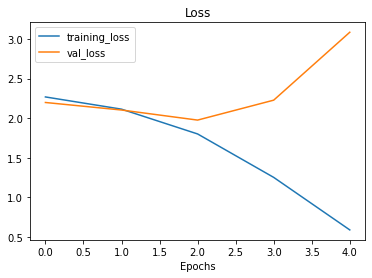

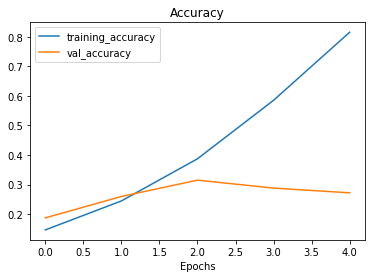

time: 104 ms (started: 2022-06-06 01:32:23 +05:30)


In [181]:
# Check out the model's loss curves on the 10 classes of data (note: this function comes from above in the notebook)
plot_loss_curves(history_9)

Woah, that's quite the gap between the training and validation loss curves.

What does this tell us?

It seems our model is **overfitting** the training set quite badly. In other words, it's getting great results on the training data but fails to generalize well to unseen data and performs poorly on the test data.

### 6. Adjust the model parameters

Due to its performance on the training data, it's clear our model is learning something. However, performing well on the training data is like going well in the classroom but failing to use your skills in real life.

Ideally, we'd like our model to perform as well on the test data as it does on the training data.

So our next steps will be to try and prevent our model overfitting. A couple of ways to prevent overfitting include:

- **Get more data** - Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples.
- **Simplify model** - If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer.
- **Use data augmentation** - Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data.
- **Use transfer learning** - Transfer learning involves leverages the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images.

> 🔑 **Note:** Preventing overfitting is also referred to as **regularization**.

If you've already got an existing dataset, you're probably most likely to try one or a combination of the last three above options first.

Since collecting more data would involve us manually taking more images of food, let's try the ones we can do from right within the notebook.

How about we simplify our model first?

To do so, we'll remove two of the convolutional layers, taking the total number of convolutional layers from four to two.

In [182]:
# Try a simplified model (removed two layers)
model_10 = Sequential([Conv2D(10, 3, 
                              activation='relu', 
                              input_shape=(224, 224, 3)),
                       MaxPool2D(),
                       Conv2D(10, 3, activation='relu'),
                       MaxPool2D(),
                       Flatten(),
                       Dense(10, activation='softmax')])

model_10.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

history_10 = model_10.fit(train_data,
                          epochs=5,
                          steps_per_epoch=len(train_data),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
  1/235 [..............................] - ETA: 1:11 - loss: 2.3846 - accuracy: 0.0625

2022-06-06 01:32:24.464848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - ETA: 0s - loss: 2.1229 - accuracy: 0.2607

2022-06-06 01:32:40.679185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 22s 91ms/step - loss: 2.1229 - accuracy: 0.2607 - val_loss: 1.9302 - val_accuracy: 0.3300
Epoch 2/5
235/235 [==============================] - 20s 84ms/step - loss: 1.8014 - accuracy: 0.3840 - val_loss: 1.8831 - val_accuracy: 0.3428
Epoch 3/5
235/235 [==============================] - 20s 83ms/step - loss: 1.4674 - accuracy: 0.5123 - val_loss: 1.9359 - val_accuracy: 0.3472
Epoch 4/5
235/235 [==============================] - 19s 82ms/step - loss: 0.9787 - accuracy: 0.6932 - val_loss: 2.2019 - val_accuracy: 0.3212
Epoch 5/5
235/235 [==============================] - 20s 83ms/step - loss: 0.5372 - accuracy: 0.8429 - val_loss: 2.6804 - val_accuracy: 0.2940
time: 1min 40s (started: 2022-06-06 01:32:23 +05:30)


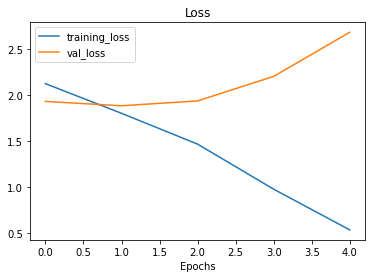

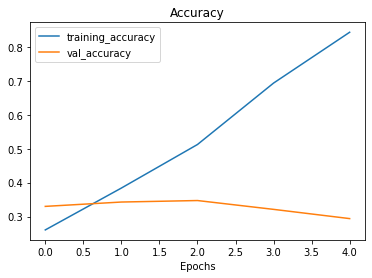

time: 99.7 ms (started: 2022-06-06 01:34:04 +05:30)


In [183]:
# Check out the loss curves of model_10
plot_loss_curves(history_10)

In [184]:
model_10.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 111, 111, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 54, 54, 10)       0         
 g2D)                                                            
                                                                 
 flatten_19 (Flatten)        (None, 29160)             0         
                                                                 
 dense_29 (Dense)            (None, 10)              

Hmm... even with a simplifed model, it looks like our model is still dramatically overfitting the training data.

What else could we try?

How about **data augmentation**?

Data augmentation makes it harder for the model to learn on the training data and in turn, hopefully making the patterns it learns more generalizable to unseen data.

To create augmented data, we'll recreate a new [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) instance, this time adding some parameters such as `rotation_range` and `horizontal_flip` to manipulate our images.

In [185]:
# Create augmented data generator instance
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             # note: this is an int not a float
                                             rotation_range=20, 
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented \
                          .flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical')

Found 7500 images belonging to 10 classes.
time: 249 ms (started: 2022-06-06 01:34:04 +05:30)


Now we've got augmented data, let's see how it works with the same model as before (`model_10`).

Rather than rewrite the model from scratch, we can clone it using a handy function in TensorFlow called [`clone_model`](https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model) which can take an existing model and rebuild it in the same format. 

The cloned version will not include any of the weights (patterns) the original model has learned. So when we train it, it'll be like training a model from scratch.

> 🔑 **Note:** One of the key practices in deep learning and machine learning in general is to **be a serial experimenter**. That's what we're doing here. Trying something, seeing if it works, then trying something else. A good experiment setup also keeps track of the things you change, for example, that's why we're using the same model as before but with different data. The model stays the same but the data changes, this will let us know if augmented training data has any influence over performance.

In [186]:
# Clone the model (use the same architecture)
model_11 = tf.keras.models.clone_model(model_10)

# Compile the cloned model (same setup as used for model_10)
model_11.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_11 = model_11.fit(train_data_augmented, # use augmented data
                          epochs=5,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5


2022-06-06 01:34:04.821536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - ETA: 0s - loss: 2.2485 - accuracy: 0.1760

2022-06-06 01:34:49.685216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 50s 211ms/step - loss: 2.2485 - accuracy: 0.1760 - val_loss: 2.0334 - val_accuracy: 0.2728
Epoch 2/5
235/235 [==============================] - 49s 210ms/step - loss: 2.0732 - accuracy: 0.2563 - val_loss: 1.9477 - val_accuracy: 0.3084
Epoch 3/5
235/235 [==============================] - 50s 211ms/step - loss: 2.0365 - accuracy: 0.2793 - val_loss: 1.8776 - val_accuracy: 0.3556
Epoch 4/5
235/235 [==============================] - 48s 206ms/step - loss: 2.0043 - accuracy: 0.3037 - val_loss: 1.9012 - val_accuracy: 0.3280
Epoch 5/5
235/235 [==============================] - 50s 212ms/step - loss: 1.9662 - accuracy: 0.3208 - val_loss: 1.8089 - val_accuracy: 0.3928
time: 4min 7s (started: 2022-06-06 01:34:04 +05:30)


You can see it each epoch takes longer than the previous model. This is because our data is being augmented on the fly on the CPU as it gets loaded onto the GPU, in turn, increasing the amount of time between each epoch.

How do our model's training curves look?

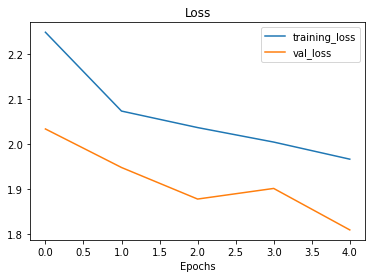

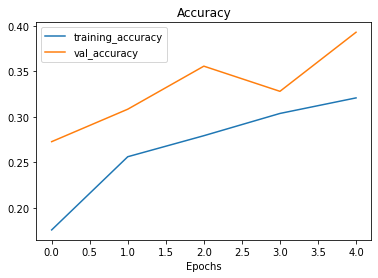

time: 102 ms (started: 2022-06-06 01:38:11 +05:30)


In [187]:
# Check out our model's performance with augmented data
plot_loss_curves(history_11)

Woah! That's looking much better, the loss curves are much closer to eachother. Although our model didn't perform as well on the augmented training set, it performed much better on the validation dataset.

It even looks like if we kept it training for longer (more epochs) the evaluation metrics might continue to improve.

### 7. Repeat until satisfied

We could keep going here. Restructuring our model's architecture, adding more layers, trying it out, adjusting the learning rate, trying it out, trying different methods of data augmentation, training for longer. But as you could image, this could take a fairly long time.

Good thing there's still one trick we haven't tried yet and that's **transfer learning**.

However, we'll save that for the next notebook where you'll see how rather than design our own models from scratch we leverage the patterns another model has learned for our own task.

In the meantime, let's make a prediction with our trained multi-class model.

## Making a prediction with our trained model

What good is a model if you can't make predictions with it?

Let's first remind ourselves of the classes our multi-class model has been trained on and then we'll download some of own custom images to work with.

In [188]:
# What classes has our model been trained on?
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

time: 1.96 ms (started: 2022-06-06 01:38:11 +05:30)


Beautiful, now let's get some of our custom images.

If you're using Google Colab, you could also upload some of your own images via the files tab.

In [189]:
# -q is for "quiet"
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

time: 9.82 s (started: 2022-06-06 01:38:11 +05:30)


Okay, we've got some custom images to try, let's use the `pred_and_plot` function to make a prediction with `model_11` on one of the images and plot it.

2022-06-06 01:38:21.689530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


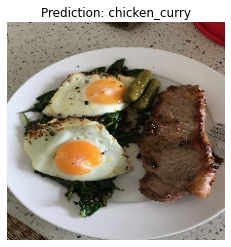

time: 259 ms (started: 2022-06-06 01:38:21 +05:30)


In [190]:
# Make a prediction using model_11
pred_and_plot(model=model_11, 
              filename="03-steak.jpeg", 
              class_names=class_names)

Hmm... it looks like our model got the prediction wrong, how about we try another?

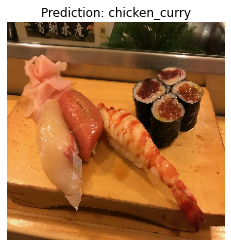

time: 194 ms (started: 2022-06-06 01:38:21 +05:30)


In [191]:
pred_and_plot(model_11, "03-sushi.jpeg", class_names)

And again, it's predicting `chicken_curry` for some reason.

How about one more?

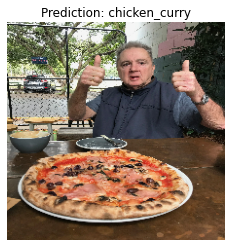

time: 174 ms (started: 2022-06-06 01:38:22 +05:30)


In [192]:
pred_and_plot(model_11, "03-pizza-dad.jpeg", class_names)

`chicken_curry` again? There must be something wrong...

I think it might have to do with our `pred_and_plot` function.

Let's makes a prediction without using the function and see where it might be going wrong.

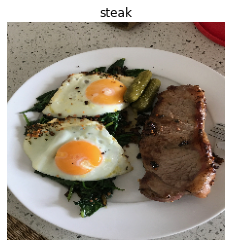

time: 175 ms (started: 2022-06-06 01:38:22 +05:30)


In [193]:
# Load in and preprocess our custom image
img = load_and_prep_image("03-steak.jpeg")

# Make a prediction
pred = model_11.predict(tf.expand_dims(img, axis=0))

# Match the prediction class to the highest prediction probability
pred_class = class_names[pred.argmax()]
plt.imshow(img)
plt.title(pred_class)
plt.axis(False);

Much better! There must be something up with our `pred_and_plot` function.

And I think I know what it is.

The `pred_and_plot` function was designed to be used with binary classification models where as our current model is a multi-class classification model.

The main difference lies in the output of the `predict` function.

In [194]:
# Check the output of the predict function
pred = model_11.predict(tf.expand_dims(img, axis=0))
pred

array([[0.04335975, 0.07493559, 0.01008797, 0.23493837, 0.07521529,
        0.09016789, 0.01309533, 0.02226693, 0.3242374 , 0.11169552]],
      dtype=float32)

time: 31.2 ms (started: 2022-06-06 01:38:22 +05:30)


Since our model has a `'softmax'` activation function and 10 output neurons, it outputs a prediction probability for each of the classes in our model.

The class with the highest probability is what the model believes the image contains.

We can find the maximum value index using [`argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) and then use that to index our `class_names` list to output the predicted class.

In [195]:
# Find the predicted class name
class_names[pred.argmax()]

'steak'

time: 1.96 ms (started: 2022-06-06 01:38:22 +05:30)


Knowing this, we can readjust our `pred_and_plot` function to work with multiple classes as well as binary classes.

In [196]:
# Adjust function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

time: 522 µs (started: 2022-06-06 01:38:22 +05:30)


Let's try it out. If we've done it right, using different images should lead to different outputs (rather than `chicken_curry` every time).

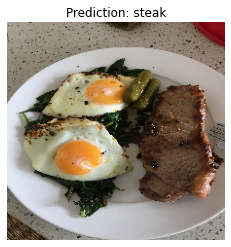

time: 161 ms (started: 2022-06-06 01:38:22 +05:30)


In [197]:
pred_and_plot(model_11, "03-steak.jpeg", class_names)

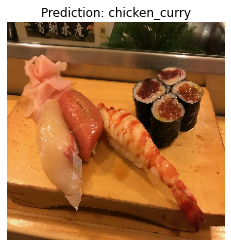

time: 171 ms (started: 2022-06-06 01:38:22 +05:30)


In [198]:
pred_and_plot(model_11, "03-sushi.jpeg", class_names)

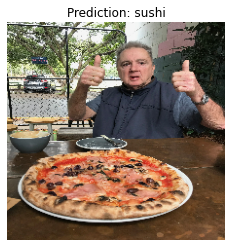

time: 185 ms (started: 2022-06-06 01:38:22 +05:30)


In [199]:
pred_and_plot(model_11, "03-pizza-dad.jpeg", class_names)

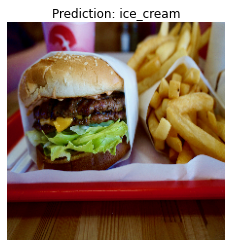

time: 262 ms (started: 2022-06-06 01:38:23 +05:30)


In [200]:
pred_and_plot(model_11, "03-hamburger.jpeg", class_names)

Our model's predictions aren't very good, this is because it's only performing at ~35% accuracy on the test dataset.

## Saving and loading our model

Once you've trained a model, you probably want to be able to save it and load it somewhere else.

To do so, we can use the [`save`](https://www.tensorflow.org/tutorials/keras/save_and_load) and [`load_model`](https://www.tensorflow.org/tutorials/keras/save_and_load) functions.

In [201]:
# Save a model
model_11.save("saved_trained_model")

INFO:tensorflow:Assets written to: saved_trained_model/assets
time: 458 ms (started: 2022-06-06 01:38:23 +05:30)


In [202]:
# Load in a model and evaluate it
loaded_model_11 = tf.keras.models.load_model("saved_trained_model")
loaded_model_11.evaluate(test_data)

 2/79 [..............................] - ETA: 3s - loss: 1.8617 - accuracy: 0.3750 

2022-06-06 01:38:24.376084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 5s 61ms/step - loss: 1.8089 - accuracy: 0.3928


[1.8089213371276855, 0.3928000330924988]

time: 5.53 s (started: 2022-06-06 01:38:23 +05:30)


In [203]:
# Compare our unsaved model's results (same as above)
model_11.evaluate(test_data)

79/79 [==============================] - 5s 61ms/step - loss: 1.8089 - accuracy: 0.3928


[1.808921217918396, 0.3928000330924988]

time: 4.9 s (started: 2022-06-06 01:38:29 +05:30)


In [204]:
%unload_ext autotime

## 🛠 Exercises

1. Spend 20-minutes reading and interacting with the [CNN explainer website](https://poloclub.github.io/cnn-explainer/). 
 * What are the key terms? e.g. explain convolution in your own words, pooling in your own words

2. Play around with the "understanding hyperparameters" section in the [CNN explainer](https://poloclub.github.io/cnn-explainer/) website for 10-minutes.
  * What is the kernel size?
  * What is the stride? 
  * How could you adjust each of these in TensorFlow code?

3. Take 10 photos of two different things and build your own CNN image classifier using the techniques we've built here.

4. Find an ideal learning rate for a simple convolutional neural network model on your the 10 class dataset.

## 📖 Extra-curriculum

1. **Watch:** [MIT's Introduction to Deep Computer Vision](https://www.youtube.com/watch?v=iaSUYvmCekI&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=3) lecture. This will give you a great intuition behind convolutional neural networks.

2. **Watch:** Deep dive on [mini-batch gradient descent](https://youtu.be/-_4Zi8fCZO4) by deeplearning.ai. If you're still curious about why we use **batches** to train models, this technical overview covers many of the reasons why.

3. **Read:** [CS231n Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/convolutional-networks/) class notes. This will give a very deep understanding of what's going on behind the scenes of the convolutional neural network architectures we're writing. 

4. **Read:** ["A guide to convolution arithmetic for deep learning"](https://arxiv.org/pdf/1603.07285.pdf). This paper goes through all of the mathematics running behind the scenes of our convolutional layers.

5. **Code practice:** [TensorFlow Data Augmentation Tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation). For a more in-depth introduction on data augmentation with TensorFlow, spend an hour or two reading through this tutorial.